In [45]:
import sys
import pandas as pd
import matplotlib.pyplot as plt 

sys.path.append('../src/construct')
sys.path.append('../data/automatic/when2heat')
from hourly_heat_demand import scale_national_annual_demand

In [5]:
space_heating = "../build/model/eurospores/space-heat-demand.csv"
water_heating = "../build/model/eurospores/water-heat-demand.csv"
annual_electricity = "../build/annual_heat_electricity_consumption.csv"
hourly_electricity = "../euro-calliope/build/model/eurospores/electricity-demand.csv"
population = "../land-eligibility/build/eurospores/population.csv"
model_year = 2016

In [6]:
space_heating_df = pd.read_csv(space_heating, index_col=0, parse_dates=True)
water_heating_df = pd.read_csv(water_heating, index_col=0, parse_dates=True)
population_df = pd.read_csv(population, index_col=0, parse_dates=True)
mapped_pop = population_df.assign(
    country_code=population_df.index.str.split('_', expand=True).get_level_values(0),
    population=population_df.population_sum,
    id=population_df.index
)
annual_electricity_df = scale_national_annual_demand(
    mapped_pop, annual_electricity, model_year, 10
)
hourly_electricity_df = pd.read_csv(hourly_electricity, index_col=0, parse_dates=True)
for k, v in {"space_heating": space_heating_df, "water_heating": water_heating_df}.items():
    _heating_elec = annual_electricity_df.filter(regex=k, axis=0).sum(level='id')
    _heating_elec_hourly = v.div(v.abs().sum()).mul(_heating_elec.abs())
    hourly_electricity_df[_heating_elec_hourly.columns] = (
        hourly_electricity_df.reindex(_heating_elec_hourly.columns, axis=1) - _heating_elec_hourly
    )

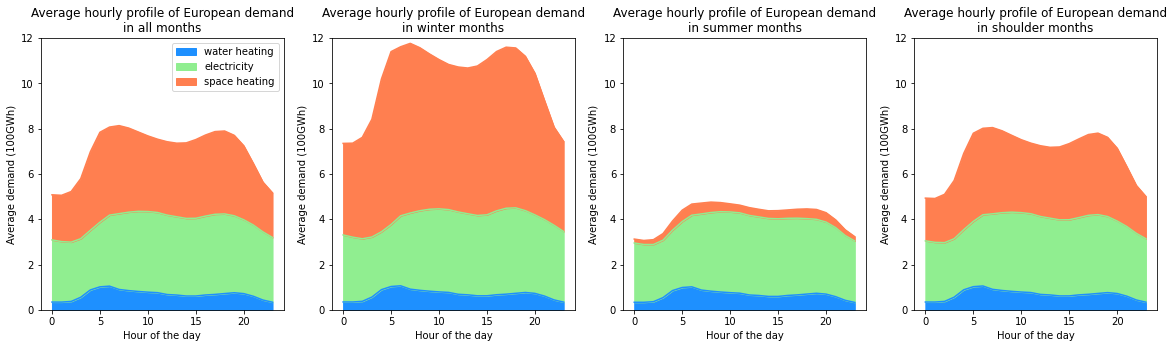

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
_ax = 0
for season, months in [('All', list(range(1, 13))), ('Winter', [12, 1, 2]), ('Summer', [6, 7, 8]), ('Shoulder', [3, 4, 5, 9, 10, 11])]:
    
    pd.concat(
        [i[i.index.month.isin(months)].sum(axis=1).groupby(i[i.index.month.isin(months)].index.hour).mean() for i in [water_heating_df, hourly_electricity_df, space_heating_df]], 
        axis=1, keys=['water heating', 'electricity', 'space heating']
    ).mul(-1).plot.area(title=f'Average hourly profile of European demand\nin {season.lower()} months', color=['dodgerblue', 'lightgreen', 'coral'], ax=ax[_ax])
    ax[_ax].set_ylabel('Average demand (100GWh)')
    ax[_ax].set_xlabel('Hour of the day')
    ax[_ax].set_ylim([0, 12])
    if _ax > 0:
        ax[_ax].get_legend().remove()
    _ax += 1